## **Final Project**
**KAIST, Spring 2021**   
**[CoE202(A)] Fundamentals of Artificial Intelligence**

**Instructor: Prof. Young-Gyu Yoon**

**Issue date: 2021.05.20.**    
**Due date: 2021.06.15.**

**convolutional neural network** for **semantic segmentation** of photographic images.

The goal is to achieve as high as possible mean Intersection of Union(mIoU) on the test dataset

This iPython notebook is the skeleton code prepared by our TAs (Changyeop Shin and Seungjae Han) for you.

**1. Import external libraries that we want to use.**

In [ ]:
import os
import sys
import time
import datetime
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
from torchvision.utils import save_image
import torchvision.transforms as transforms
from tqdm.auto import tqdm


!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Seoul /etc/localtime

**2. Mount the google drive.**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Autoreload in case that the custom modules are changed
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


**3. Import custom modules.
Below is a list of python modules that contain useful functions.**

**You need to make sure that you upload the files on 'filepath'.**

*  **util.py** : dataloader, mIoU calculator, transform functions.
*  **model_baseline.py**: semantic segmentation model.

In [ ]:
filepath = "/content/drive/MyDrive/Machine_learning/Final_project" # indicate path of workspace, change the path suited to your Google drive setting
sys.path.append(filepath)

from util import *
from model_baseline import *

# New Section

**4. Unzip the compressed data file (.zip).**

In [ ]:
# Check the current filepath and file lists in there
%cd $filepath 
!pwd 
!ls 
![ -d "CoE202Spring_finalproject_dataset" ] &&  echo "Directory $d found." || unzip -q CoE202Spring_finalproject_dataset.zip # once you unzip, then do not again
!ls

/content/drive/MyDrive/Machine_learning/Final_project
/content/drive/MyDrive/Machine_learning/Final_project
coe202_final_project_train_skeleton.ipynb  model_baseline.py  util.py
CoE202Spring_finalproject_dataset.zip	   __pycache__
coe202_final_project_train_skeleton.ipynb  model_baseline.py
CoE202Spring_finalproject_dataset	   __pycache__
CoE202Spring_finalproject_dataset.zip	   util.py


**5. Define arguments such as hyper-parameters, environment variables.**

In [ ]:
n_epoch = 400 # number of training epochs
batch_size = 32
learning_rate = 5*1e-4
crop_size = 128
experiment = "exp_colab"  # the name of experiment to save your model and optimizer.

# Make directories for saving outcomes of experiment
os.makedirs(f"{filepath}/{experiment}", exist_ok=True)
os.makedirs(f"{filepath}/results/training", exist_ok=True)
os.makedirs(f"{filepath}/results/validation", exist_ok=True)

6.00 Augmentation

In [ ]:
dataAugment(root=f"{filepath}/CoE202Spring_finalproject_dataset")

**6. Load training and validation datasets with data transform functions.**

In [ ]:
# Class information
classes = ['background',
'aeroplane',
'bicycle',
'boat',
'bus',
'car',
'motorbike',
'person',
'train',
'boundary'] # For convenience, the classes are denoted as corresponding indexes (0~9) in this project
# Notice that the boundary class (index : 9) is ignored to evaluate mIoU!

color_transform = Colorize() # mapping probability maps to color maps


# You can modify custom transform functions
custom_transform = []

# Don't change input_transform, target_transform
input_transform = [transforms.ToTensor()]

target_transform = [ToLabel(),
    Relabel(4, 3),
    Relabel(6, 4),
    Relabel(7, 5),
    Relabel(14, 6),
    Relabel(15, 7),
    Relabel(19, 8),
    Relabel(255, 9),
]

input_transform = transforms.Compose(input_transform)
target_transform = transforms.Compose(target_transform)

dataset = CoE_Dataset(root=f"{filepath}/CoE202Spring_finalproject_dataset",
                input_transform=input_transform,
                target_transform=target_transform, train=True)

#dataset = CoE_Test_Dataset(root=f"{filepath}/CoE202Spring_finalproject_test_dataset", # root should be the path of your test dataset
                #input_transform=input_transform)
print('Total number of images : {}'.format(len(dataset)))

# ------------
# Load dataset
# ------------

# You can change dataset spliting/loading strategies
n_train = math.floor(0.9*len(dataset)) # (default) 90% of the data for training
n_val = len(dataset) - math.floor(0.9*len(dataset)) # (default) 10% of the data for validation

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=True
                                        )
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=True
                                        )

# Print the size of image/mask and unique classes (0~9)
img, mask, _ = next(iter(train_loader))
print('image & mask size : {}, {}'.format(img.size(), mask.size())) # size of the image and mask
print(torch.unique(mask)) # unique classes

Total number of images : 5000
image & mask size : torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


**7. Glance at some sample data.**

As the 1st step of learning process, it's indispensable to understand input data.

Then, we can get some hints for designing the network and training scheme.

In [ ]:
(sample_batch, sample_label, _) = next(iter(train_loader))

fig = plt.figure(figsize=(12, 14))
for i in range(2):
    for j in range(0):
        fig.add_subplot(4, 4, (i * 4 + j * 2 + 1))
        plt.imshow(sample_batch[i*4+j].permute(1, 2, 0))
        classes_name = [classes[index] for index in torch.unique(sample_label[i*4+j]) if not index == 9]
        plt.title('class : ' + str(classes_name))
        fig.add_subplot(4, 4, (i * 4 + j * 2 + 1+ 1))
        plt.imshow(color_transform(sample_label[i*4+j]).permute(1, 2, 0))
plt.suptitle("Sample images")

Text(0.5, 0.98, 'Sample images')

<Figure size 864x1008 with 0 Axes>

**8. Set-up the training environment (model, loss function, optimizer, etc).**


In [ ]:
# You can modify the loss, the model and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=9).cuda() # Ignore the index 9 indiciating 'boundaries' for calculating loss
model = UNet().cuda()
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
 ㅜㅠㅍ

best_model_state, best_optim_state = None, None
latest_model_state, latest_optim_state = None, None

**9. Check your segmentation network.**

You can define your own network in **model_baseline.py.** 

In [ ]:
print('The network architecture is as follows.')
print(model)

The network architecture is as follows.
UNet(
  (dec1): UNetDec(
    (down): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.99, affine=True, track_running_stats=False)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
  )
  (dec2): UNetDec(
    (down): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.99, affine=True, track_running_stats=False)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
  )
  (dec3): UNetDec(
    (down): Sequential(
      (0): Conv2d(

**10. Monitor learning process in the Tensorboard.**

Tensorboard is a visualization toolkit (part of tensorflow) that help us monitor the learning procedures (loss, accuracy, etc). 

We are using PyTorch here, but we can still use the Tensorboard!

*   We will execute the Tensorboard now. At this point, we will get 'No dashboards are active for the current data set.' message, as nothing is connected to this board.
*   In the training for-loop below, there is summary.scalar() function which writes specific scalars to the Tensorboard!
*   You can click the refresh button in the Tensorboard, or set automatic refresh, 'Reload data' in the setting!

In [ ]:
%load_ext tensorboard
from tensorflow import summary
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = summary.create_file_writer(f"{filepath}/runs/{current_time}")

%tensorboard --logdir="{filepath}/runs" # you can manually remove unnecessary logs in this folder

**11. Train your segmentation network.**

You can monitor the training procedure through the Tensorboard above.

In [ ]:
start = time.time()
best_mIoU = 0.0
for epoch in tqdm(range(n_epoch)):
    scheduler.step()
    train_total_loss, valid_total_loss = 0.0, 0.0

    # # --------------
    # # Training step
    # # --------------

    model.train()

    # Load mini-batches and do training
    total_inter = 0
    total_union = 0
    # At first loading, it may be stuck for a while..
    for _, (images, labels, _) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Predict the pixel-wise probability map indicating class prediction
        pred = model(images)

        # Calculate loss
        loss = criterion(pred, labels[:, 0, :, :])
        
        # Backpropagate the loss to update network's weights
        optim.zero_grad()
        loss.backward()
        optim.step()

        train_total_loss += loss.item()
        
        # Calculate total intersection and union for each epoch
        area_inter, area_union = batch_intersection_union(pred, labels[:, 0, :, :], 9)
        total_inter += area_inter
        total_union += area_union
    train_IoU_class = total_inter / total_union # indicate the IoU for each classes(bins)
    train_mIoU = train_IoU_class.mean().item() # indicate the mean IoU across all classes


    # ----------------
    # Validation step
    # ----------------

    # For validation, you do not need to calculate the gradient
    with torch.no_grad():
        model.eval()
        total_inter = 0
        total_union = 0
        # Load mini-batches and do validation
        for _, (images, labels, _) in enumerate(valid_loader):
            images = images.cuda()
            labels = labels.cuda()

            pred = model(images)
            loss = criterion(pred, labels[:, 0, :, :])

            valid_total_loss += loss.item()

            # Calculate total intersection and union for each epoch
            area_inter, area_union = batch_intersection_union(pred, labels[:, 0, :, :], 9)
            total_inter += area_inter
            total_union += area_union
        val_IoU_class = total_inter / total_union # indicate the IoU for each classes(bins)
        val_mIoU = val_IoU_class.mean().item() # indicate the mean IoU across all classes

        # Record the losses in forms of tensorboard scalars
        with summary_writer.as_default():
            summary.scalar('train_loss', train_total_loss, step=epoch)
            summary.scalar('valid_loss', valid_total_loss, step=epoch)
            summary.scalar('train_mIoU', train_mIoU, step=epoch)
            summary.scalar('val_mIoU', val_mIoU, step=epoch)

        # Store the latest and best accuracy models and optimizers
        latest_model_state = model.state_dict()
        latest_optim_state = optim.state_dict()
        
        if best_mIoU < val_mIoU:
            best_mIoU = val_mIoU
            best_model_state = model.state_dict()
            best_optim_state = optim.state_dict()

    # Print training logs and save intermediate validation results during training
    if epoch % 10 == 0 or epoch == n_epoch - 1: 
        print(f"""\n{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())} || [{epoch}/{n_epoch}], train_loss = {train_total_loss:.4f}, valid_loss = {valid_total_loss:.4f}, train_mIoU = {train_mIoU:.4f}, val_mIoU = {val_mIoU:.4f}, , best mIoU = {best_mIoU:.4f}""")
        stacked_imgs = torch.cat(torch.split(images, 1, dim=0), dim=3)
        stacked_labels = torch.cat(torch.split(labels, 1, dim=0), dim=3)[0]
        stacked_preds = torch.cat(torch.split(pred, 1, dim=0), dim=3)[0]
        img_grid = torch.cat((stacked_imgs, color_transform(stacked_labels).unsqueeze(0).cuda(),color_transform(stacked_preds.max(0)[1].unsqueeze(0)).unsqueeze(0).cuda()), -2)
        save_image(img_grid, "results/training/%d.png" % epoch, normalize=False)

elapsed = time.time() - start
print(f"End of training, elapsed time : {elapsed // 60} min {elapsed % 60} sec.")

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3672: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")



2021-06-15 10:17:34 || [0/400], train_loss = 171.3760, valid_loss = 16.2568, train_mIoU = 0.0712, val_mIoU = 0.0720, , best mIoU = 0.0720

2021-06-15 10:28:56 || [10/400], train_loss = 137.0742, valid_loss = 14.3963, train_mIoU = 0.1315, val_mIoU = 0.1335, , best mIoU = 0.1484

2021-06-15 10:40:09 || [20/400], train_loss = 131.4472, valid_loss = 13.3987, train_mIoU = 0.1473, val_mIoU = 0.1692, , best mIoU = 0.1692

2021-06-15 10:51:20 || [30/400], train_loss = 117.8978, valid_loss = 12.8546, train_mIoU = 0.1903, val_mIoU = 0.1940, , best mIoU = 0.2148

2021-06-15 11:02:30 || [40/400], train_loss = 109.2887, valid_loss = 11.6107, train_mIoU = 0.2316, val_mIoU = 0.2411, , best mIoU = 0.2411

2021-06-15 11:13:39 || [50/400], train_loss = 103.6149, valid_loss = 10.4976, train_mIoU = 0.2679, val_mIoU = 0.2684, , best mIoU = 0.2684

2021-06-15 11:24:47 || [60/400], train_loss = 97.5302, valid_loss = 10.3882, train_mIoU = 0.2884, val_mIoU = 0.2745, , best mIoU = 0.2879

2021-06-15 11:35:53 |

**12. Save the predicted results for validation dataset.**

Also, let's check the validation mIoU.

In [ ]:
model.eval()
mIoU = 0.0
total_inter = 0
total_union = 0
valid_loader_save = torch.utils.data.DataLoader(valid_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        drop_last=True
                                        )

for _, (images, labels, filename) in enumerate(valid_loader_save):
      images = images.cuda()
      labels = labels.cuda()
      # Predict the pixel-wise probability map indicating class prediction
      pred = model(images)
      area_inter, area_union = batch_intersection_union(pred, labels[:, 0, :, :], 9)
      total_inter += area_inter
      total_union += area_union
      labels = color_transform(labels[0]).unsqueeze(0).cuda()
      pred = color_transform(pred[0].max(0)[1].unsqueeze(0)).unsqueeze(0).cuda()

      # Save the validation results to .png
      save_image(images, "results/validation/{}_img.png".format(filename[0]))
      save_image(pred.float(), "results/validation/{}_pred.png".format(filename[0]))
      save_image(labels.float(), "results/validation/{}_label.png".format(filename[0]))
mIoU = (total_inter / total_union).mean().item()
print('The final mIoU : {}'.format(mIoU))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3672: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


The final mIoU : 0.17093853652477264


**13. Visualize the sample validation image in the shell.**

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([128, 128]) torch.Size([128, 128])
mIoU : 0.51554274559021
tensor([0, 3, 9])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3672: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Text(0.5, 1.0, 'Pred')

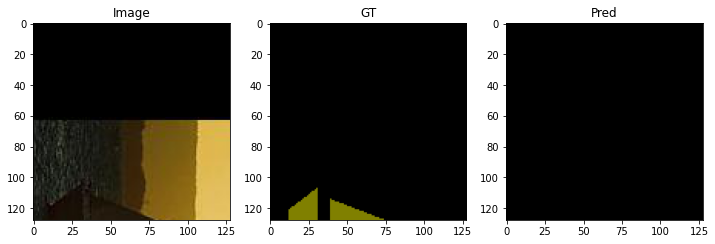

In [ ]:
training_sample = True

if training_sample == True:
  (sample_batch, sample_label,_) = next(iter(train_loader))
else:
  (sample_batch, sample_label,_) = next(iter(valid_loader))


index = 9
model.eval()
sample_batch
sample_label
sample_output = model(sample_batch.cuda())


print(sample_batch[index].size())
print(sample_label[index].size())
print(sample_output[index].max(0)[1].unsqueeze(0).size())

label_one = sample_label[index].squeeze(0)
pred_one = sample_output[index].max(0)[1]
print(label_one.size(), pred_one.size())
with torch.no_grad():
    inter, union = batch_intersection_union(sample_output, sample_label[:, 0, :, :].cuda(), 9)
    mIoU = (inter / union).mean().item()
    print(f"mIoU : {mIoU}")

fig = plt.figure(figsize=(12, 12))
fig.add_subplot(1, 3, 1)
plt.imshow(sample_batch[index].permute(1, 2, 0))
plt.title("Image")
fig.add_subplot(1, 3, 2)
plt.imshow(color_transform(sample_label[index]).permute(1, 2, 0))
plt.title("GT")
print(torch.unique(sample_label[index]))
fig.add_subplot(1, 3, 3)
plt.imshow(color_transform(pred_one.unsqueeze(0)).permute(1, 2, 0))
plt.title("Pred")

**14. Save parameters of the model and the optimizer.**

By default, it saves parameters of the latest and best model and optimizer.

Following your strategy, you can freely select them by yourself.

In [ ]:
if best_model_state is not None and best_optim_state is not None:
    torch.save(best_model_state, f"{filepath}/{experiment}/best_model_state_dict.pt")
    torch.save(best_optim_state, f"{filepath}/{experiment}/best_optim_state_dict.pt")
    torch.save(latest_model_state, f"{filepath}/{experiment}/latest_model_state_dict.pt")
    torch.save(latest_optim_state, f"{filepath}/{experiment}/latest_optim_state_dict.pt")
    print("Successfully saved.")

Successfully saved.
